# [GD-01] NLP_SentencePiece
"Going Deeper Node 2. Making Nice Vocab Dictionary" / 2022. 03. 23 (WED) 이형주

## Contents
---
- **1. Environment Setup**
- **2. Modeling**
- **3. Project Retrospective**

## Rubric 평가기준
---

|  평가문항  |  상세기준  |
|:---------|:---------|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.
|3. SentencePiece의 성능을 다각도로 비교분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.

## 1. Environment Setup

In [1]:
# 필요한 라이브러리 로드
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 9.2 MB/s 
     |████████████████████████████████| 448 kB 64.3 MB/s 


In [3]:
import konlpy

In [4]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 8.0 MB/s 


In [5]:
# Colab Pro GPU 정보
# 새로운 환경에서 진행하는 만큼 실행시켜 본다.
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar 23 13:57:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# Colab Pro Ram 정보
# 새로운 환경에서 진행하는 만큼 실행시켜 본다.
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


**원래는 Google Drive에 업로드 후 로드하려 하였으나, 1Gbps 인터넷 환경에서도 업로드 시간이 총 40분 정도로 과다하게 소요되는 관계로 웹 로드로 대체한다. 사용하는 방법은 아래 링크를 참조하여 urlretrieve, urllib.request를 활용하였다.**

Source: https://han-py.tistory.com/320

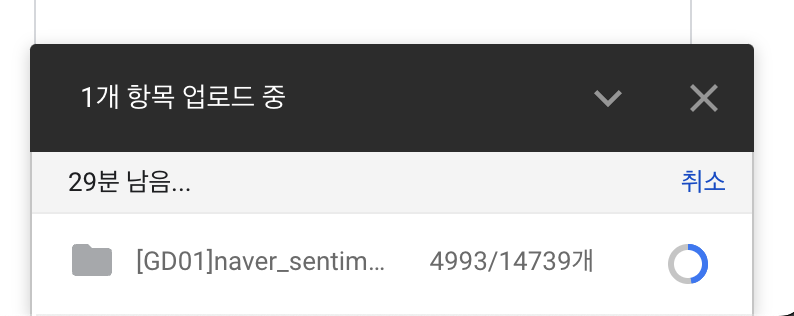

In [7]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f36cad6ab10>)

In [8]:
import pandas as pd
naver_movie_review_df = pd.read_table('ratings.txt')
print('데이터 전체 갯수는:', len(naver_movie_review_df), '개 입니다.')

데이터 전체 갯수는: 200000 개 입니다.


In [9]:
# index로 번호가, id에는 작성자 아이디가, document에 리뷰 내용이 있다.
naver_movie_review_df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


### EDA & Data Pre-Processing

** 결측치부터 찾아서 전처리 해보자. 위에서 데이터 전체 갯수는 200,000개 였다.**



In [10]:
# 결측치 숫자를 체크해본다.
naver_movie_review_df.isnull().sum()

id          0
document    8
label       0
dtype: int64

In [11]:
naver_movie_review_df = naver_movie_review_df.dropna(how='any')
print(naver_movie_review_df.isnull().sum)

<bound method NDFrame._add_numeric_operations.<locals>.sum of            id  document  label
0       False     False  False
1       False     False  False
2       False     False  False
3       False     False  False
4       False     False  False
...       ...       ...    ...
199995  False     False  False
199996  False     False  False
199997  False     False  False
199998  False     False  False
199999  False     False  False

[199992 rows x 3 columns]>


In [12]:
# 여기에서 혹시 모를 중복 데이터를 한번 더 거른다. 갯수는 194,544개가 되었다.
duplicate_data_removed = naver_movie_review_df.drop_duplicates('document')
print('결측치 제거에, 중복 데이터까지 거른 리뷰 갯수는:',len(duplicate_data_removed),'개 입니다.')

결측치 제거에, 중복 데이터까지 거른 리뷰 갯수는: 194543 개 입니다.


In [13]:
# 깨끗하게 정리한 'document', 리뷰가 있는 영역을 naver_movie_review_cleaned로 선언한다.
naver_movie_review_cleaned = duplicate_data_removed['document']

문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


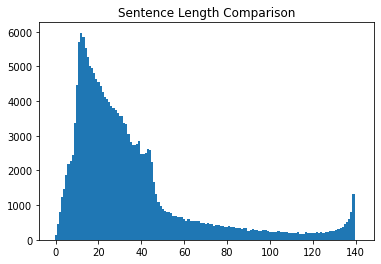

In [14]:
# 최장 1000자, 최저 0자로 해서 naver_movie_review_cleaned에 있는 리뷰들 길이가 어떻게 분포되어 있는지를 본다.
# 도식화된 그림에서 가로는 리뷰의 길이, 세로는 리뷰의 갯수가 되겠다.

min_len = 1000
max_len = 0
sum_len = 0

for sen in naver_movie_review_cleaned:
    length = len(sen)
    if min_len > length: 
        min_len = length
        
    if max_len < length: 
        max_len = length
    
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(naver_movie_review_cleaned))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in naver_movie_review_cleaned:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Comparison")
plt.show()

# 평균 10~50자 선에서 대부분의 데이터가 분포되어 있다.
# 50~140자에 있는 데이터들이 정말 중요한게 아니라면, 50자 이후는 다 날려도 될 것 같다.

In [15]:
# 각 문장 길이별 리뷰 분포를 수치로 비교해 보자

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('샘플 길이가 %s 이하 비율은: %s'%(max_len, (cnt / len(nested_list))*100),'입니다.')

below_threshold_len(36, naver_movie_review_cleaned)  # 평균
below_threshold_len(142, naver_movie_review_cleaned)  # 최장 
below_threshold_len(70, naver_movie_review_cleaned)  # 중앙
below_threshold_len(50, naver_movie_review_cleaned)
below_threshold_len(60, naver_movie_review_cleaned)

샘플 길이가 36 이하 비율은: 66.08616090016089 입니다.
샘플 길이가 142 이하 비율은: 100.0 입니다.
샘플 길이가 70 이하 비율은: 88.66523082300571 입니다.
샘플 길이가 50 이하 비율은: 82.05640912291884 입니다.
샘플 길이가 60 이하 비율은: 85.86739178484962 입니다.


In [16]:
# 최장으로 쓰신 142자 글은 무엇으로 적혀 있을까

def who_are_you_for_long_sentence(raw, length):
    count = 0

    for sen in raw:
      if len(sen) == length:
          print(sen)
          count += 1
          if count > 100: return

who_are_you_for_long_sentence(naver_movie_review_cleaned, 142)

영화 초반을 보면서 ' 좀 허항된 . 황당한 코믹스런 ' 연출이 되겠다란 생각을 하고 보기시작했는데 .. 연주가 처음 시작되는 부분에서 저도 모르게 눈가가 초촉해 지기시작하더군요 .. 이유는 모르겠네요 ... 자유에 대한 갈증과 박해에 대한 내용을 &gt


In [34]:
# 최단으로 쓰신 1글자 글은 무엇으로 적혀 있을까

def who_are_you_for_long_sentence(raw, length):
    count = 0

    for sen in raw:
      if len(sen) == length:
          print(sen)
          count += 1
          if count > 100: return

who_are_you_for_long_sentence(naver_movie_review_cleaned, 1)

굿
핡
휴
시
ㅋ
ㅇ
‥
O
갑
ㅎ
.
올
헷
g
♥
짱
ㅆ
굳
잼
ㅁ
?
애
흠
!
찜
b
,
1
9
♬
ㅗ
ㄳ
ㄴ
호
a
d
f
음
헐
캬
린
업
乃
ㅠ
;
·
k
움
ㄱ
쩜
-
군
ㅉ
훗
z
쨩
뿌
♡
하
h
ㅍ
꽉
토
귯
아
오
ㅣ
봐
웅
네
ㅂ
꿈
헉
와
뻑
걍
헝
우
즛
풉
4
쀍
ㄹ
삼
쒯
즐
함
0
진
악
풋
쩝
욜
ㄷ
흐
싫
ㅜ
잏
허
엿
쉣


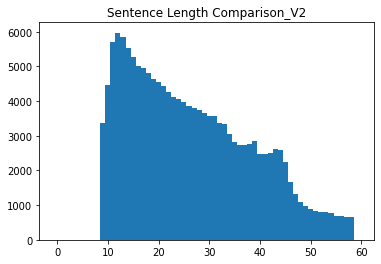

In [27]:
max_len = 60   
min_len = 10

# 10글자 ~ 60글자로 제한하여 모은다.

modified_corpus_final = [s for s in naver_movie_review_cleaned if (len(s) < max_len) & (len(s) >= min_len)]
modified_corpus_label = []  
for sentence, label in zip(naver_movie_review_df['document'], naver_movie_review_df['label']):    
    if (len(sentence) < max_len):     
        modified_corpus.append(sentence)  
        modified_corpus_label.append(label) 
  
sentence_length = np.zeros((max_len), dtype=int)

for sen in modified_corpus_final:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Comparison_V2")
plt.show()

In [30]:
# 처음에 데이터 열었을 때 갯수
print(len(naver_movie_review_df))
# 결측치 제거, 중복 제거 후 데이터 갯수
print(len(naver_movie_review_cleaned))
# 데이터 범위를 60자로 제한한 후 데이터 갯수
print(len(modified_corpus_final))

199992
194543
153554


## 2. Modeling

In [31]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/haven-jeon/ko_en_neural_machine_translation/master/korean_parallel_corpora/korean-english-v1/korean-english-park.train.ko", filename="korean-english-park.train.ko")

('korean-english-park.train.ko', <http.client.HTTPMessage at 0x7f36bdc6d390>)

In [32]:
import sentencepiece as spm
temp_train_file = urllib.request.urlretrieve("https://raw.githubusercontent.com/haven-jeon/ko_en_neural_machine_translation/master/korean_parallel_corpora/korean-english-v1/korean-english-park.train.ko", filename="korean-english-park.train.ko")
vocab_size = 8000

# Unigram 8K
spm.SentencePieceTrainer.Train('--input=korean-english-park.train.ko --model_prefix=korean_spm_unigram_8k --vocab_size=8000'.format(temp_train_file, vocab_size))
# Unigram 16K
spm.SentencePieceTrainer.Train('--input=korean-english-park.train.ko --model_prefix=korean_spm_unigram_16k --vocab_size=16000'.format(temp_train_file, vocab_size*2))
# BPE 8K
spm.SentencePieceTrainer.Train('--input=korean-english-park.train.ko --model_prefix=korean_spm_bpe_8k --model_type=bpe --vocab_size=8000'.format(temp_train_file, vocab_size))
# BPE 16K
spm.SentencePieceTrainer.Train('--input=korean-english-park.train.ko --model_prefix=korean_spm_bpe_16k --model_type=bpe --vocab_size=16000'.format(temp_train_file, vocab_size*2))

In [33]:
!ls -l korean_spm_unigram_8k*
!ls -l korean_spm_unigram_16k*
!ls -l korean_spm_bpe_8k*
!ls -l korean_spm_bpe_16k*

-rw-r--r-- 1 root root 376471 Mar 23 14:02 korean_spm_unigram_8k.model
-rw-r--r-- 1 root root 145963 Mar 23 14:02 korean_spm_unigram_8k.vocab
-rw-r--r-- 1 root root 534523 Mar 23 14:03 korean_spm_unigram_16k.model
-rw-r--r-- 1 root root 310962 Mar 23 14:03 korean_spm_unigram_16k.vocab
-rw-r--r-- 1 root root 371579 Mar 23 14:03 korean_spm_bpe_8k.model
-rw-r--r-- 1 root root 116816 Mar 23 14:03 korean_spm_bpe_8k.vocab
-rw-r--r-- 1 root root 524521 Mar 23 14:03 korean_spm_bpe_16k.model
-rw-r--r-- 1 root root 259754 Mar 23 14:03 korean_spm_bpe_16k.vocab


In [35]:
def performance_test(model):
    s = spm.SentencePieceProcessor()
    s.Load(model)

    # SentencePiece를 활용한 sentence -> encoding
    tokensIDs = s.EncodeAsIds('.')
    print(tokensIDs)

    # SentencePiece를 활용한 sentence -> encoded pieces
    print(s.SampleEncodeAsPieces('죽음과결혼은미룰수록좋다.',1, 0.0))

    # SentencePiece를 활용한 encoding -> sentence 복원
    print(s.DecodeIds(tokensIDs))

In [36]:
# Unigram Vocab 8K
performance_test(model='korean_spm_unigram_8k.model')
print('korean_spm_unigram_8k')

# Unigram Vocab 16K
performance_test(model='korean_spm_unigram_16k.model')
print('korean_spm_unigram_16k')

# BPE Vocab 8K
performance_test(model='korean_spm_bpe_8k.model')
print('korean_spm_bpe_8k')

# BPE Vocab 16K
performance_test(model='korean_spm_bpe_16k.model')
print('korean_spm_bpe_16k')

[3, 4]
['▁죽음', '과', '결', '혼', '은', '미', '룰', '수록', '좋', '다', '.']
.
korean_spm_unigram_8k
[5, 3]
['▁죽음', '과', '결혼', '은', '미', '룰', '수록', '좋', '다', '.']
.
korean_spm_unigram_16k
[6673, 6676]
['▁죽음', '과', '결', '혼', '은', '미', '룰', '수록', '좋', '다', '.']
.
korean_spm_bpe_8k
[11810]
['▁죽음', '과', '결혼', '은', '미', '룰', '수록', '좋', '다', '.']
.
korean_spm_bpe_16k


### Tokenizing

In [37]:
def sp_tokenize(s, corpus, model):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("korean_spm_bpe_16k.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [38]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm_bpe_16k.model')

my_corpus = ['안촉촉한 초코칩 나라에 살던 안촉촉한 초코칩이 촉촉한 초코칩 나라의 촉촉한 초코칩을 보고 촉촉한 초코칩이 되고 싶어서 촉촉한 초코칩 나라에 갔다.', '촉촉한 초코칩 나라의 문지기가 `넌 촉촉한 초코칩이 아니고 안촉촉한 초코칩이니까 안촉촉한 초코칩나라에서 살아`라고 했다.']
tensor, word_index, index_word = sp_tokenize(s, my_corpus, 'korean_spm_unigram_16k')
print(tensor)

[[  177 15182 15182 14685   381 14904 15735  1635 14677   266 14844   177
  15182 15182 14685   381 14904 15735 14674   920 15182 14685   381 14904
  15735  7181   920 15182 14685   381 14904 15735 14681   372   920 15182
  14685   381 14904 15735 14674  2417  2898 14691   920 15182 14685   381
  14904 15735  1635 14677  6305 14676]
 [  920 15182 14685   381 14904 15735  7181   166 14682   544  5534 15712
    920 15182 14685   381 14904 15735 14674 10899   177 15182 15182 14685
    381 14904 15735 14674  6511   177 15182 15182 14685   381 14904 15735
   1348     6  2136 15505    38   402 14676     0     0     0     0     0
      0     0     0     0     0     0]]


### Rubric 평가기준
---

|  평가문항  |  상세기준  |
|:---------|:---------|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?

### Model Training

In [109]:
tensor, word_index, index_word = sp_tokenize(s, modified_corpus_final, 'kor_spm_unigram_16k')

In [106]:
from sklearn.model_selection import train_test_split
filtered_label = np.array(modified_corpus_label)
x_train, x_val, y_train, y_val = train_test_split(tensor, modified_corpus_final, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [85]:
print(len(x_train), len(x_test), len(x_val))
print(len(y_train), len(y_test), len(y_val))

98274 24569 30711
98274 24569 30711


In [86]:
from tensorflow.keras.initializers import Constant

vocab_size = vocab_size
word_vector_dim = 32  

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim,))
            
model_LSTM.add(keras.layers.LSTM(128)) 
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          256000    
                                                                 
 lstm_4 (LSTM)               (None, 128)               82432     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 338,561
Trainable params: 338,561
Non-trainable params: 0
_________________________________________________________________


In [87]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

In [107]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
batch_size=1024
history = model_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose=1)

results = model_LSTM.evaluate(x_test, y_test, verbose=1)
print(results)

ValueError: ignored

## 3. Project Retrospective

+ 프로젝트 진행 전반에 있어 각종 오류 때문에 피말리는(?) 수정을 했지만 해결을 하지 못했다. 분명 오류없이 넘어갔던 부분에 다시 에러가 생기면서 모델 구현까지만 하고 이후 동작은 실패했다.
+ 한국어를 전처리하는 것이 이전에도 어려웠는데, 지금도 여전히 어렵다. 친해지기 위해 더 많이 노력해야 할 듯 하다.
+ 파일을 다운로드 받아서 로드하는 것이 아니라, 깃헙에서 바로 가져다가 쓰도록 설계한 것은 한 단계 발전했다.
+ 이번에는 Colab Pro에서 모두 해결하려고 갖은 노력을 다 했는데 LMS 상에서는 동일 코드를 시도하지 않았다. 만약 LMS에서 정상 작동이 되고, 코드에 문제가 없다면 환경셋팅 이슈일 수 있어서 면밀하게 살펴볼 예정이다.